<a href="https://colab.research.google.com/github/MalshanNimesh99/Research/blob/master/Brain_Tumor_detection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp -r "/content/gdrive/MyDrive/Research/BrainTumorData.zip" "/content"

In [3]:
import zipfile
archive = zipfile.ZipFile('/content/gdrive/MyDrive/Research/BrainTumorData.zip')
archive.extractall('/content')

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [6]:
#count no of images in class   0- brain tumor    1- healthy
ROOT_DIR = "/content/BrainTumorData/Brain Tumor Data Set"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

In [7]:
number_of_images.items()

dict_items([('Brain Tumor', 270), ('Healthy', 203)])

In [8]:
#create train folder

if not os.path.exists("./train"):
  os.mkdir("./train")

  for dir in os.listdir(ROOT_DIR):
    os.makedirs("./train/"+dir)
    for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir) ) ,
                                size= (math.floor(70/100*number_of_images[dir])-2) ,
                                replace=False ):
      
      O = os.path.join(ROOT_DIR,dir,img)
      D = os.path.join('./train', dir)
      shutil.copy(O,D)
      os.remove(O)
else:
  print("Train folder is already exsist")

In [9]:
def dataFolder(p, split):
  #create train folder

  if not os.path.exists("./"+p):
    os.mkdir("./"+p)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+p+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir)),
                                  size= (math.floor(split*number_of_images[dir])-2),
                                  replace=False):
        
        O = os.path.join(ROOT_DIR,dir,img)
        D = os.path.join('./'+p, dir)
        shutil.copy(O,D)
        os.remove(O)
  else:
    print(f"{p} folder is already exsist")

In [10]:
dataFolder("train", 0.6)

train folder is already exsist


In [11]:
dataFolder("val", 0.2)

In [12]:
dataFolder("test", 0.1)

In [13]:
#count no of images in class   0- brain tumor    1- healthy
ROOT_DIR = "/content/BrainTumorData/Brain Tumor Data Set"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))
number_of_images.items()

dict_items([('Brain Tumor', 6), ('Healthy', 7)])

**Model** **Build**

In [14]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
import keras
from keras.preprocessing.image import ImageDataGenerator

In [15]:
#CNN Model

model = Sequential()

model.add(Conv2D(filters= 16, kernel_size= (3,3), activation= 'relu', input_shape= (224,224,3) ))

model.add(Conv2D(filters= 36, kernel_size= (3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size= (2,2)))

model.add(Conv2D(filters= 64, kernel_size= (3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size= (2,2)))

model.add(Conv2D(filters= 128, kernel_size= (3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size= (2,2)))

model.add(Dropout(rate= 0.25))

model.add(Flatten())
model.add(Dense(units=64 , activation= 'relu'))
model.add(Dropout(rate= 0.25))
model.add(Dense(units=1 , activation= 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [16]:
model.compile(optimizer='adam' , loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

preparing data using data genarator

In [17]:
def preprocessingImages1(path):
  
 # input : path
 # output : pre processed images

 image_date = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, rescale= 1/255, horizontal_flip= True)
 image = image_date.flow_from_directory(directory = path , target_size = (224,224), batch_size= 32, class_mode= 'binary')

 return image

In [18]:
path = "/content/train"
train_data = preprocessingImages1(path)

Found 327 images belonging to 2 classes.


In [19]:
def preprocessingImages2(path):
  
 # input : path
 # output : pre processed images

 image_date = ImageDataGenerator(rescale= 1/255)
 image = image_date.flow_from_directory(directory = path , target_size = (224,224), batch_size= 32, class_mode= 'binary')

 return image

In [20]:
path = "/content/test"
test_data = preprocessingImages2(path)

Found 43 images belonging to 2 classes.


In [21]:
path = "/content/val"
val_data = preprocessingImages2(path)

Found 90 images belonging to 2 classes.


Early stopping and model check point

In [22]:
from keras.callbacks import ModelCheckpoint , EarlyStopping

#early stopping
es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience= 3, verbose= 1, mode='auto')

# model checkpoint
mc = ModelCheckpoint(monitor="val_accuracy", filepath="./bestmodel.h5", verbose= 1, save_best_only=True , mode='auto')

cd = [es,mc]

Model Training

In [23]:
hs = model.fit_generator(generator= train_data, 
                         steps_per_epoch=8 , 
                         epochs= 30, 
                         verbose= 1, 
                         validation_data = val_data, 
                         validation_steps= 8, 
                         callbacks= cd )

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.7321 - accuracy: 0.6133


Epoch 1: val_accuracy improved from -inf to 0.64444, saving model to ./bestmodel.h5
8/8 [==============================] - 14s 604ms/step - loss: 0.7321 - accuracy: 0.6133 - val_loss: 0.6439 - val_accuracy: 0.6444
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.6191 - accuracy: 0.6926

8/8 [==============================] - 3s 370ms/step - loss: 0.6191 - accuracy: 0.6926
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.6926

8/8 [==============================] - 3s 359ms/step - loss: 0.6219 - accuracy: 0.6926
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.5924 - accuracy: 0.7056

8/8 [==============================] - 3s 358ms/step - loss: 0.5924 - accuracy: 0.7056
Epoch 5/30
8/8 [==============================] - ETA: 0s - loss: 0.6201 - accuracy: 0.6753

8/8 [==============================] - 3s 355ms/step - loss: 0.6201 - accuracy: 0.6753
Epoch 6/30
8/8 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.6970

8/8 [==============================] - 3s 351ms/step - loss: 0.5954 - accuracy: 0.6970
Epoch 7/30
8/8 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.7143

8/8 [==============================] - 3s 343ms/step - loss: 0.5600 - accuracy: 0.7143
Epoch 8/30
8/8 [==============================] - ETA: 0s - loss: 0.5544 - accuracy: 0.7446

8/8 [==============================] - 3s 356ms/step - loss: 0.5544 - accuracy: 0.7446
Epoch 9/30
8/8 [==============================] - ETA: 0s - loss: 0.5725 - accuracy: 0.7446

8/8 [==============================] - 3s 363ms/step - loss: 0.5725 - accuracy: 0.7446
Epoch 10/30
8/8 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.7013

8/8 [==============================] - 3s 362ms/step - loss: 0.5603 - accuracy: 0.7013
Epoch 11/30
8/8 [==============================] - ETA: 0s - loss: 0.5756 - accuracy: 0.6970

8/8 [==============================] - 3s 350ms/step - loss: 0.5756 - accuracy: 0.6970
Epoch 12/30
8/8 [==============================] - ETA: 0s - loss: 0.5172 - accuracy: 0.7835

8/8 [==============================] - 3s 347ms/step - loss: 0.5172 - accuracy: 0.7835
Epoch 13/30
8/8 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.7792

8/8 [==============================] - 3s 403ms/step - loss: 0.5115 - accuracy: 0.7792
Epoch 14/30
8/8 [==============================] - ETA: 0s - loss: 0.5075 - accuracy: 0.7792

8/8 [==============================] - 3s 360ms/step - loss: 0.5075 - accuracy: 0.7792
Epoch 15/30
8/8 [==============================] - ETA: 0s - loss: 0.4556 - accuracy: 0.7706

8/8 [==============================] - 3s 349ms/step - loss: 0.4556 - accuracy: 0.7706
Epoch 16/30
8/8 [==============================] - ETA: 0s - loss: 0.4894 - accuracy: 0.7532

8/8 [==============================] - 3s 407ms/step - loss: 0.4894 - accuracy: 0.7532
Epoch 17/30
8/8 [==============================] - ETA: 0s - loss: 0.4163 - accuracy: 0.8009

8/8 [==============================] - 3s 349ms/step - loss: 0.4163 - accuracy: 0.8009
Epoch 18/30
8/8 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.7706

8/8 [==============================] - 3s 351ms/step - loss: 0.4792 - accuracy: 0.7706
Epoch 19/30
8/8 [==============================] - ETA: 0s - loss: 0.4200 - accuracy: 0.8086

8/8 [==============================] - 3s 397ms/step - loss: 0.4200 - accuracy: 0.8086
Epoch 20/30
8/8 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8242

8/8 [==============================] - 3s 390ms/step - loss: 0.4455 - accuracy: 0.8242
Epoch 21/30
8/8 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.8268

8/8 [==============================] - 3s 352ms/step - loss: 0.3913 - accuracy: 0.8268
Epoch 22/30
8/8 [==============================] - ETA: 0s - loss: 0.4503 - accuracy: 0.7879

8/8 [==============================] - 3s 354ms/step - loss: 0.4503 - accuracy: 0.7879
Epoch 23/30
7/8 [=========================>....] - ETA: 0s - loss: 0.4697 - accuracy: 0.8080

8/8 [==============================] - 3s 358ms/step - loss: 0.4647 - accuracy: 0.8095
Epoch 24/30
8/8 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.8312

8/8 [==============================] - 3s 361ms/step - loss: 0.3940 - accuracy: 0.8312
Epoch 25/30
8/8 [==============================] - ETA: 0s - loss: 0.4051 - accuracy: 0.8139

8/8 [==============================] - 5s 646ms/step - loss: 0.4051 - accuracy: 0.8139
Epoch 26/30
8/8 [==============================] - ETA: 0s - loss: 0.3932 - accuracy: 0.8281

8/8 [==============================] - 5s 562ms/step - loss: 0.3932 - accuracy: 0.8281
Epoch 27/30
8/8 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.8182

8/8 [==============================] - 3s 355ms/step - loss: 0.4180 - accuracy: 0.8182
Epoch 28/30
8/8 [==============================] - ETA: 0s - loss: 0.4124 - accuracy: 0.8242

8/8 [==============================] - 3s 400ms/step - loss: 0.4124 - accuracy: 0.8242
Epoch 29/30
8/8 [==============================] - ETA: 0s - loss: 0.3731 - accuracy: 0.8398

8/8 [==============================] - 3s 398ms/step - loss: 0.3731 - accuracy: 0.8398
Epoch 30/30
8/8 [==============================] - ETA: 0s - loss: 0.3701 - accuracy: 0.8359

8/8 [==============================] - 3s 388ms/step - loss: 0.3701 - accuracy: 0.8359


In [24]:
#model graphical representaion

h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

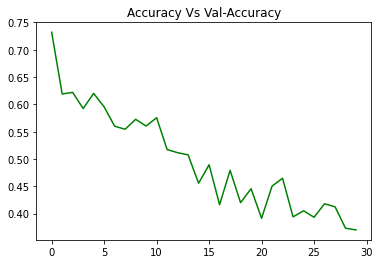

In [28]:
import matplotlib.pyplot as plt

plt.plot(h['val_loss'], c ="red")
plt.plot(h['loss'],c ="green")

plt.title("Accuracy Vs Val-Accuracy")
plt.show()

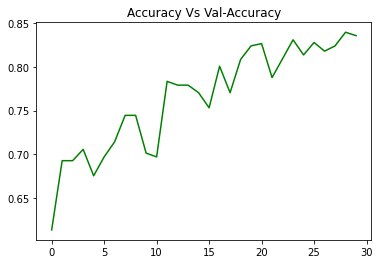

In [29]:
plt.plot(h['val_accuracy'], c ="red")
plt.plot(h['accuracy'],c ="green")

plt.title("Accuracy Vs Val-Accuracy")
plt.show()

In [ ]:
#model accuracy
from keras.models import load_model

model = load_model("/content/bestmodel.h5")

In [30]:
acc = model.evaluate_generator(test_data)[1]
print(f"the accuracy of the model is {acc*100} %")

the accuracy of the model is 86.04651093482971 %


In [34]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

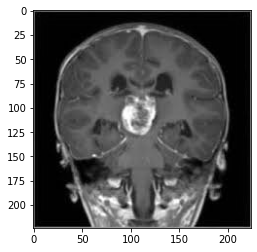

1/1 [==============================] - 0s 27ms/step
[0]
The MRI is having a Tumor


In [54]:
path = "/content/test/Brain Tumor/image(58).jpg"

img = load_img(path, target_size = (224,224))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr.shape

input_arr = np.expand_dims(input_arr, axis=0)

#pred = model.predict_classes(input_arr)
pred = np.argmax(model.predict(input_arr), axis=1)
pred
print(pred)
if pred == 0:
  print("The MRI is having a Tumor")
else:
  print("The MRI is not having a Tumor")